<a href="https://colab.research.google.com/github/ana-bioinfo-ngs/RNA-Seq_Pancreatic_Cancer_using_R/blob/main/Pancreatic_Cancer_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install
install.packages("BiocManager")
BiocManager::install("DESeq2")
library(DESeq2)
library(tidyverse)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘XVector’, ‘formatR’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘Seqinfo’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘MatrixGenerics’, ‘RcppArmadillo’


Old packages: 'cpp11', 'rappdirs', 'xfun', 'xml2'

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following objects are m

In [ ]:
# Read the TSV file
tsv_data <- read_tsv("/content/E-MTAB-10411-raw-counts.tsv")

# Write the data frame to a CSV file
write_csv(tsv_data, path = "raw-counts.csv")

Rows: 56748 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Gene ID, Gene Name
dbl (8): ERR5873116, ERR5873117, ERR5873118, ERR5873119, ERR5873120, ERR5873...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“The `path` argument of `write_csv()` is deprecated as of readr 1.4.0.
ℹ Please use the `file` argument instead.”


In [ ]:
# Read the TSV file
tsv_data <- read_tsv("/content/E-MTAB-10411-experiment-design.tsv")

# Write the data frame to a CSV file
write_csv(tsv_data, path = "experiment-design.csv")

Rows: 8 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (14): Run, Sample Characteristic[age], Sample Characteristic[development...
lgl  (4): Sample Characteristic Ontology Term[age], Sample Characteristic On...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
counts <- read.csv("/content/raw-counts_1.csv", row.names = 1)

In [ ]:
coldata <- read.csv("/content/experiment-design_1.csv", row.names = 1)

In [ ]:
all(rownames(coldata) %in% colnames(counts))

[1] TRUE

In [ ]:
coldata <- coldata[colnames(counts), ,drop = FALSE]

In [ ]:
# Checks whether: Sample names in the count matrix match the sample names in metadata
all(colnames(counts) == rownames(coldata))

[1] TRUE

Data Cleaning & Filtering

In [ ]:
# Ensure counts are integers
counts <- round(counts)

In [ ]:
head(counts)

,ERR5873116,ERR5873117,ERR5873118,ERR5873119,ERR5873120,ERR5873121,ERR5873122,ERR5873123
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,2455,2766,1921,1857,1245,3823,1424,2188
ENSMUSG00000000003,0,0,0,0,0,0,0,0
ENSMUSG00000000028,53,114,85,180,9,150,33,53
ENSMUSG00000000031,172,236,70,331,154,1255,96,194
ENSMUSG00000000037,37,26,13,13,5,49,14,12
ENSMUSG00000000049,0,0,0,0,5,2,0,0


In [ ]:
# Filter low-expression genes
# Count how many samples have ≥10 reads
# Keep the gene only if this happens in at least 3 samples
keep_genes <- rowSums(counts >= 10) >= 3

In [ ]:
# Keeps only the genes that passed the filtering rule
counts_filtered <- counts[keep_genes, ]

In [ ]:
cat("Genes before filtering:", nrow(counts), "\n")

Genes before filtering: 56748 


In [ ]:
cat("Genes after filtering:", nrow(counts_filtered), "\n")

Genes after filtering: 20143 


Normalization Using DESeq2

In [ ]:
coldata <- as.data.frame(coldata)

In [ ]:
head(coldata,8)

,Sample.Characteristic.individual.,condition
,<chr>,<chr>
ERR5873116,WT_1,Reference
ERR5873117,WT_2,Reference
ERR5873118,WT_3,Reference
ERR5873119,WT_4,Reference
ERR5873120,KO_1,Test
ERR5873121,KO_2,Test
ERR5873122,KO_3,Test
ERR5873123,KO_4,Test


In [ ]:
dds <- DESeqDataSetFromMatrix(
  countData = counts_filtered,
  colData   = coldata,
  design    = ~ condition
)


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [ ]:
dds <- estimateSizeFactors(dds)

In [ ]:
normalized_counts <- counts(dds, normalized = TRUE)

In [ ]:
log_normalized_counts <- log2(normalized_counts + 1)

In [ ]:
write.csv(
  normalized_counts,
  file = "normalized_counts_1.csv"
)

In [ ]:
write.csv(
  log_normalized_counts,
  file = "log_normalized_counts_1.csv"
)

Quality Control using Hierarchical Clustering

In [ ]:
install.packages("pheatmap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(pheatmap)

In [ ]:
cluster_data <- log_normalized_counts

In [ ]:
gene_variance <- apply(cluster_data, 1, var)

In [ ]:
top_genes <- names(sort(gene_variance, decreasing = TRUE))[1:500]

In [ ]:
cluster_data <- cluster_data[top_genes, ]

In [ ]:
write.csv(
  cluster_data,
  file = "top_500_high_variance_genes_1.csv"
)


In [ ]:
annotation_col <- data.frame(
  condition = coldata$condition
)

In [ ]:
rownames(annotation_col) <- colnames(cluster_data)

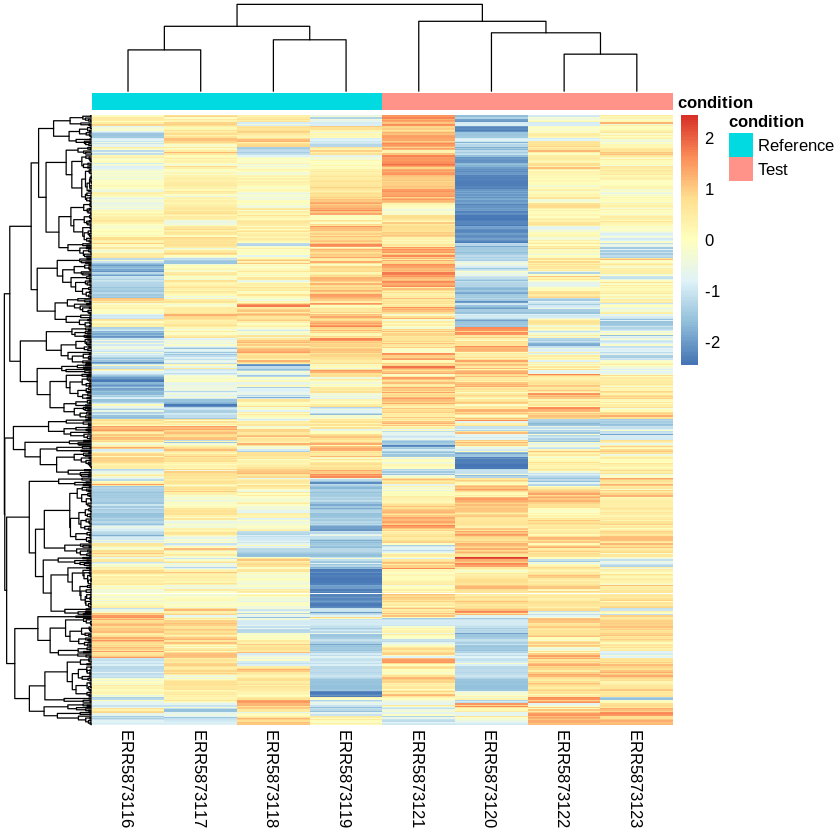

In [ ]:
pheatmap(
  cluster_data,
  scale = "row",
  clustering_distance_rows = "correlation",
  clustering_distance_cols = "correlation",
  clustering_method = "complete",
  annotation_col = annotation_col,
  show_rownames = FALSE,
  fontsize_col = 10
)

Differential Expression Testing

In [ ]:
table(coldata$condition)


Reference      Test 
        4         4 

In [ ]:
dds <- DESeq(dds)

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [ ]:
res <- results(dds)

In [ ]:
res_ordered <- res[order(res$padj), ]

In [ ]:
head(res_ordered)

log2 fold change (MLE): condition Test vs Reference 
Wald test p-value: condition Test vs Reference 
DataFrame with 6 rows and 6 columns
                     baseMean log2FoldChange     lfcSE      stat      pvalue
                    <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000059824   1046.361       -3.93552  0.254663  -15.4538 7.11062e-54
ENSMUSG00000092837 101700.266        2.19330  0.153803   14.2605 3.85953e-46
ENSMUSG00000055866    925.636       -2.70436  0.191476  -14.1237 2.71170e-45
ENSMUSG00000027800    406.424        2.14388  0.167398   12.8071 1.49609e-37
ENSMUSG00000119520    717.567        2.85497  0.243724   11.7139 1.08145e-31
ENSMUSG00000007655   1228.680        2.02930  0.174048   11.6594 2.05496e-31
                          padj
                     <numeric>
ENSMUSG00000059824 1.25915e-49
ENSMUSG00000092837 3.41723e-42
ENSMUSG00000055866 1.60062e-41
ENSMUSG00000027800 6.62320e-34
ENSMUSG00000119520 3.83008e-28
ENSMUSG00000007655 6.06487e-28

In [ ]:
res_clean <- res_ordered[!is.na(res_ordered$padj), ]

In [ ]:
head(res_clean)

log2 fold change (MLE): condition Test vs Reference 
Wald test p-value: condition Test vs Reference 
DataFrame with 6 rows and 6 columns
                     baseMean log2FoldChange     lfcSE      stat      pvalue
                    <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000059824   1046.361       -3.93552  0.254663  -15.4538 7.11062e-54
ENSMUSG00000092837 101700.266        2.19330  0.153803   14.2605 3.85953e-46
ENSMUSG00000055866    925.636       -2.70436  0.191476  -14.1237 2.71170e-45
ENSMUSG00000027800    406.424        2.14388  0.167398   12.8071 1.49609e-37
ENSMUSG00000119520    717.567        2.85497  0.243724   11.7139 1.08145e-31
ENSMUSG00000007655   1228.680        2.02930  0.174048   11.6594 2.05496e-31
                          padj
                     <numeric>
ENSMUSG00000059824 1.25915e-49
ENSMUSG00000092837 3.41723e-42
ENSMUSG00000055866 1.60062e-41
ENSMUSG00000027800 6.62320e-34
ENSMUSG00000119520 3.83008e-28
ENSMUSG00000007655 6.06487e-28

In [ ]:
alpha <- 0.05
lfc_threshold <- 1

In [ ]:
sig_genes <- res_clean[
  res_clean$padj < alpha &
  abs(res_clean$log2FoldChange) >= lfc_threshold,
]

In [ ]:
upregulated <- sig_genes[sig_genes$log2FoldChange > 0, ]
downregulated <- sig_genes[sig_genes$log2FoldChange < 0, ]

In [ ]:
nrow(upregulated)
nrow(downregulated)

[1] 1037

[1] 399

In [ ]:
write.csv(
  upregulated,
  file = "upregulated_genes.csv"
)

In [ ]:
write.csv(
  downregulated,
  file = "downregulated_genes.csv"
)

Gene Classification

In [ ]:
upregulated
downregulated

log2 fold change (MLE): condition Test vs Reference 
Wald test p-value: condition Test vs Reference 
DataFrame with 1037 rows and 6 columns
                     baseMean log2FoldChange     lfcSE      stat      pvalue
                    <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000092837 101700.266        2.19330  0.153803   14.2605 3.85953e-46
ENSMUSG00000027800    406.424        2.14388  0.167398   12.8071 1.49609e-37
ENSMUSG00000119520    717.567        2.85497  0.243724   11.7139 1.08145e-31
ENSMUSG00000007655   1228.680        2.02930  0.174048   11.6594 2.05496e-31
ENSMUSG00000032328   2579.061        1.64049  0.141974   11.5549 6.97599e-31
...                       ...            ...       ...       ...         ...
ENSMUSG00000029641    25.6037        1.56627  0.618440   2.53261   0.0113217
ENSMUSG00000016200    37.1860        1.92541  0.760350   2.53226   0.0113329
ENSMUSG00000025491    38.8290        1.62865  0.643278   2.53179   0.0113481
ENSMUSG000000

log2 fold change (MLE): condition Test vs Reference 
Wald test p-value: condition Test vs Reference 
DataFrame with 399 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000059824  1046.361       -3.93552  0.254663 -15.45382 7.11062e-54
ENSMUSG00000055866   925.636       -2.70436  0.191476 -14.12375 2.71170e-45
ENSMUSG00000028957  1302.982       -2.80216  0.256049 -10.94385 7.11183e-28
ENSMUSG00000038550   128.217       -3.99501  0.394285 -10.13229 3.97227e-24
ENSMUSG00000039062  4902.534       -1.39151  0.151593  -9.17922 4.34223e-20
...                      ...            ...       ...       ...         ...
ENSMUSG00000029720   25.0976       -1.74580  0.680240  -2.56645   0.0102745
ENSMUSG00000028068   98.7105       -1.14066  0.446308  -2.55578   0.0105951
ENSMUSG00000086938   64.9548       -2.13206  0.837435  -2.54594   0.0108983
ENSMUSG00000089712  112.5

In [ ]:
upregulated$gene <- rownames(upregulated)
downregulated$gene <- rownames(downregulated)

In [ ]:
gene_classification <- rbind(
  data.frame(gene = upregulated$gene,
             log2FoldChange = upregulated$log2FoldChange,
             padj = upregulated$padj,
             class = "Upregulated"),

  data.frame(gene = downregulated$gene,
             log2FoldChange = downregulated$log2FoldChange,
             padj = downregulated$padj,
             class = "Downregulated")
)

In [ ]:
head(gene_classification)
table(gene_classification$class)

,gene,log2FoldChange,padj,class
,<chr>,<dbl>,<dbl>,<chr>
1,ENSMUSG00000092837,2.193303,3.417230e-42,Upregulated
2,ENSMUSG00000027800,2.143884,6.623205e-34,Upregulated
3,ENSMUSG00000119520,2.854968,3.830080e-28,Upregulated
4,ENSMUSG00000007655,2.029297,6.064874e-28,Upregulated
5,ENSMUSG00000032328,1.640486,1.764726e-27,Upregulated
6,ENSMUSG00000022820,1.708152,3.286014e-27,Upregulated



Downregulated   Upregulated 
          399          1037 

In [ ]:
write.csv(gene_classification,
          "gene_classification_DESeq2.csv",
          row.names = FALSE)

Visualization

Volcano Plot

In [ ]:
volcano_data <- as.data.frame(res)
volcano_data$gene <- rownames(volcano_data)

In [ ]:
volcano_data$significance <- "Not significant"

volcano_data$significance[
  volcano_data$padj < 0.05 & volcano_data$log2FoldChange >= 1
] <- "Upregulated"

volcano_data$significance[
  volcano_data$padj < 0.05 & volcano_data$log2FoldChange <= -1
] <- "Downregulated"

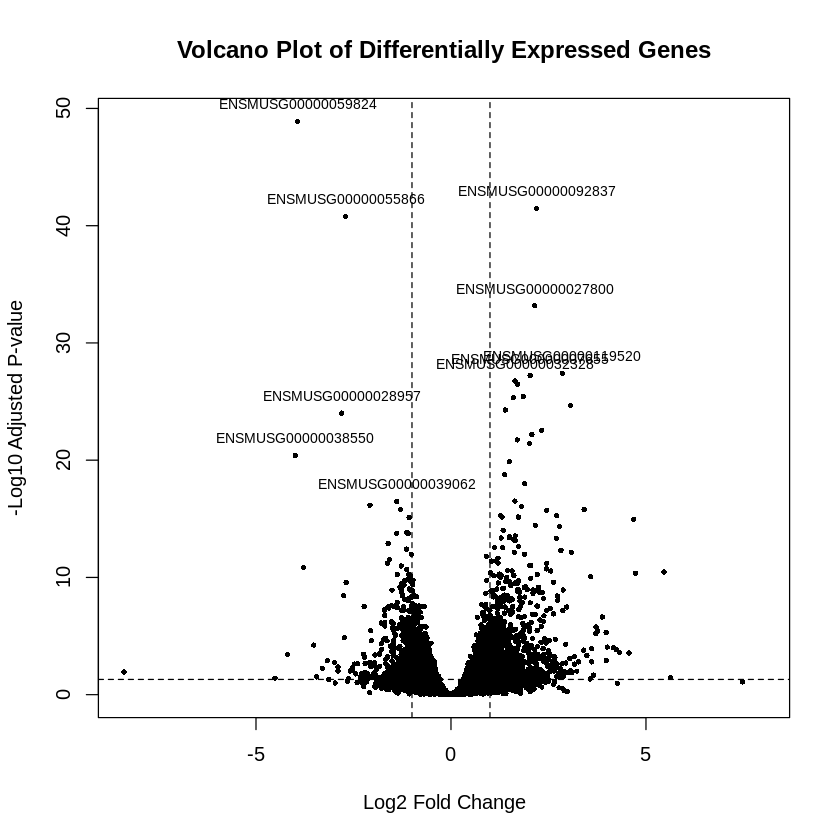

In [ ]:
plot(
  volcano_data$log2FoldChange,
  -log10(volcano_data$padj),
  pch = 16,
  cex = 0.6,
  xlab = "Log2 Fold Change",
  ylab = "-Log10 Adjusted P-value",
  main = "Volcano Plot of Differentially Expressed Genes"
)

abline(v = c(-1, 1), lty = 2)
abline(h = -log10(0.05), lty = 2)

# Label top 5 upregulated genes
top_up <- volcano_data[
  volcano_data$significance == "Upregulated",
]

top_up <- top_up[order(top_up$padj), ][1:5, ]

# Label top 5 downregulated genes
top_down <- volcano_data[
  volcano_data$significance == "Downregulated",
]

top_down <- top_down[order(top_down$padj), ][1:5, ]

# Add labels
text(
  top_up$log2FoldChange,
  -log10(top_up$padj),
  labels = top_up$gene,
  pos = 3,
  cex = 0.7
)

text(
  top_down$log2FoldChange,
  -log10(top_down$padj),
  labels = top_down$gene,
  pos = 3,
  cex = 0.7
)


In [ ]:
install.packages("ggplot2")
install.packages("ggrepel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(ggplot2)
library(ggrepel)

In [ ]:
volcano_data <- as.data.frame(res)
volcano_data$gene <- rownames(volcano_data)

volcano_data$significance <- "Not significant"
volcano_data$significance[
  volcano_data$padj < 0.05 & volcano_data$log2FoldChange >= 1
] <- "Upregulated"
volcano_data$significance[
  volcano_data$padj < 0.05 & volcano_data$log2FoldChange <= -1
] <- "Downregulated"

In [ ]:
top_up <- volcano_data[
  volcano_data$significance == "Upregulated" & !is.na(volcano_data$padj),
]
top_up <- top_up[order(top_up$padj), ][1:5, ]


top_down <- volcano_data[
  volcano_data$significance == "Downregulated" & !is.na(volcano_data$padj),
]
top_down <- top_down[order(top_down$padj), ][1:5, ]

Warning message:
“Removed 2435 rows containing missing values or values outside the scale range
(`geom_point()`).”


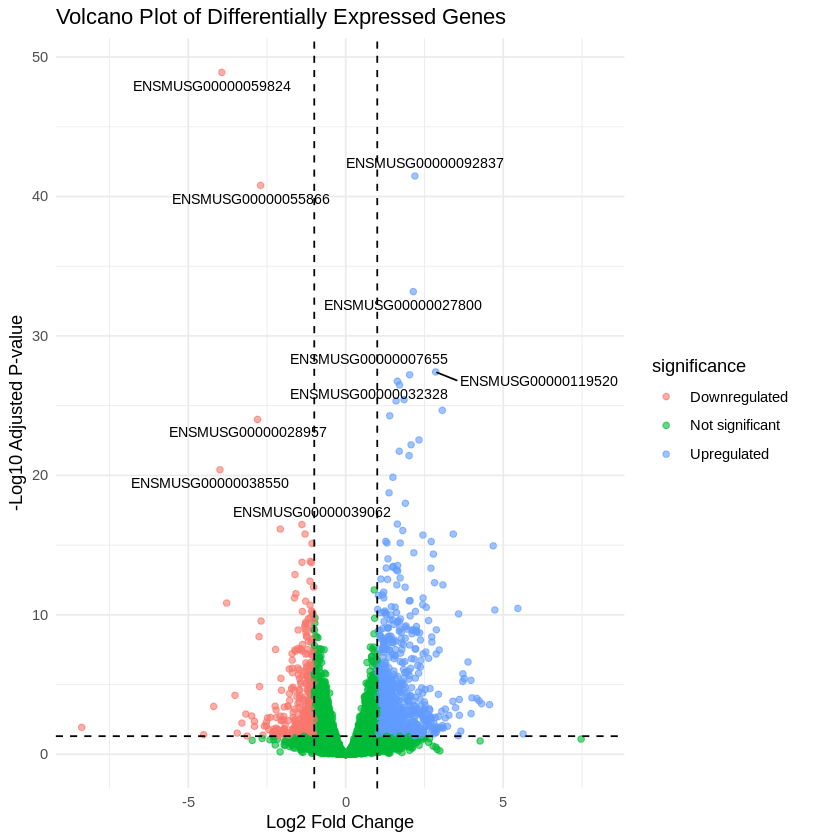

In [ ]:
ggplot(volcano_data, aes(x = log2FoldChange, y = -log10(padj))) +

  geom_point(aes(color = significance), alpha = 0.6, size = 1.5) +

  geom_vline(xintercept = c(-1, 1), linetype = "dashed") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed") +

  geom_text_repel(
    data = rbind(top_up, top_down),
    aes(label = gene),
    size = 3,
    max.overlaps = Inf
  ) +

  labs(
    title = "Volcano Plot of Differentially Expressed Genes",
    x = "Log2 Fold Change",
    y = "-Log10 Adjusted P-value"
  ) +

  theme_minimal()

Heatmap

In [ ]:
top_de_genes <- rownames(sig_genes)[1:50]

In [ ]:
heatmap_data <- log_normalized_counts[top_de_genes, ]

In [ ]:
annotation_col <- data.frame(
  condition = coldata$condition
)
rownames(annotation_col) <- colnames(heatmap_data)

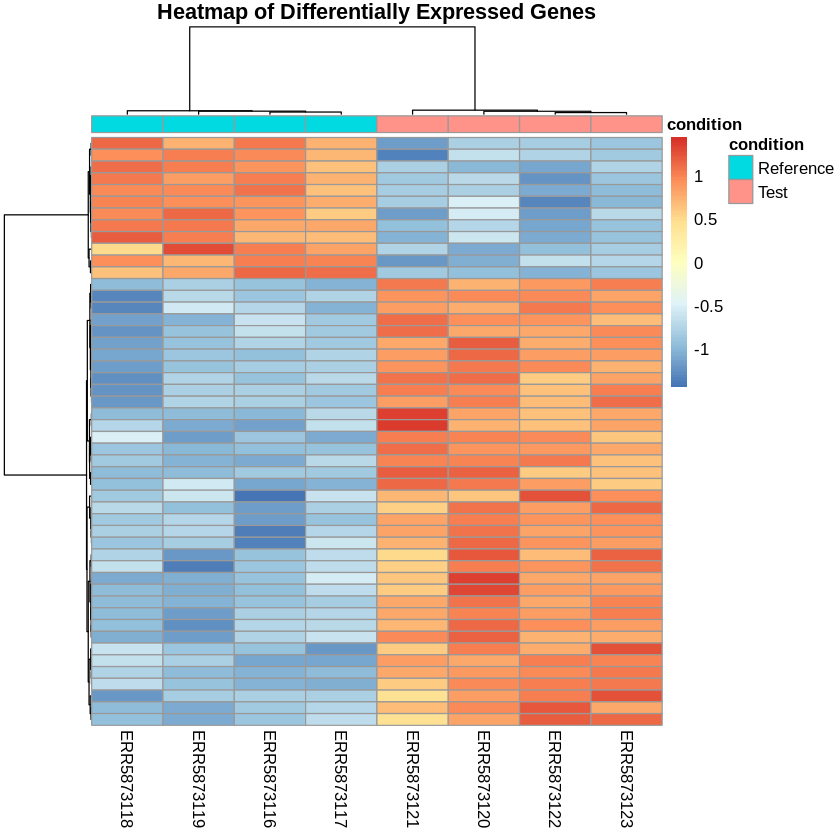

In [ ]:
pheatmap(
  heatmap_data,
  scale = "row",
  clustering_distance_cols = "correlation",
  clustering_distance_rows = "correlation",
  clustering_method = "complete",
  annotation_col = annotation_col,
  show_rownames = FALSE,
  main = "Heatmap of Differentially Expressed Genes"
)

Gene Enrichment

In [ ]:
BiocManager::install("org.Mm.eg.db")

library(clusterProfiler)
library(org.Mm.eg.db)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.22 (BiocManager 1.30.27), R 4.5.2 (2025-10-31)

Installing package(s) 'org.Mm.eg.db'

Old packages: 'cpp11', 'rappdirs', 'xfun', 'xml2'





In [ ]:
up_genes <- upregulated$gene
down_genes <- downregulated$gene

In [ ]:
head(up_genes)

[1] "ENSMUSG00000092837" "ENSMUSG00000027800" "ENSMUSG00000119520"
[4] "ENSMUSG00000007655" "ENSMUSG00000032328" "ENSMUSG00000022820"

In [ ]:
up_entrez <- bitr(
  up_genes,
  fromType = "ENSEMBL",
  toType   = "ENTREZID",
  OrgDb    = org.Mm.eg.db
)


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(up_genes, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Mm.eg.db):
“11.86% of input gene IDs are fail to map...”


In [ ]:
down_entrez <- bitr(
  down_genes,
  fromType = "ENSEMBL",
  toType   = "ENTREZID",
  OrgDb    = org.Mm.eg.db
)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(down_genes, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Mm.eg.db):
“12.78% of input gene IDs are fail to map...”


In [ ]:
head(up_entrez)
nrow(up_entrez)

,ENSEMBL,ENTREZID
,<chr>,<chr>
1,ENSMUSG00000092837,85029
2,ENSMUSG00000027800,17112
3,ENSMUSG00000119520,115490317
4,ENSMUSG00000007655,12389
5,ENSMUSG00000032328,69981
6,ENSMUSG00000022820,68194


[1] 924

Gene Ontology (GO) enrichment

In [ ]:
go_up <- enrichGO(
  gene          = up_entrez$ENTREZID,
  OrgDb         = org.Mm.eg.db,
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 0.05,
  readable      = TRUE
)

go_down <- enrichGO(
  gene          = down_entrez$ENTREZID,
  OrgDb         = org.Mm.eg.db,
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 0.05,
  readable      = TRUE
)

KEGG pathway enrichment

In [ ]:
kegg_up <- enrichKEGG(
  gene         = up_entrez$ENTREZID,
  organism     = "mmu",
  pvalueCutoff = 0.05
)

kegg_down <- enrichKEGG(
  gene         = down_entrez$ENTREZID,
  organism     = "mmu",
  pvalueCutoff = 0.05
)

Reading KEGG annotation online: "https://rest.kegg.jp/link/mmu/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/mmu"...

kegg_category.rda is not found, download it online...



In [ ]:
write.csv(as.data.frame(go_up), "GO_upregulated.csv")
write.csv(as.data.frame(go_down), "GO_downregulated.csv")
write.csv(as.data.frame(kegg_up), "KEGG_upregulated.csv")
write.csv(as.data.frame(kegg_down), "KEGG_downregulated.csv")